# Feature Importance

### Introduction

Now that we have trained a model that fits pretty well, the next component is to move through the process of reducing and selecting our features.  In this lesson, we'll use permutation feature importance to do so.

Let's load up our data where we last left off.

### Loading our Data

In [11]:
import pandas as pd
url = "https://raw.githubusercontent.com/jigsawlabs-student/feature-selection/master/listings_train_df.csv"

train_validate_df = pd.read_csv(url)

Then we can separate our feature and target variables.

In [12]:
target_cols = ['price']
X = train_validate_df.drop(columns = target_cols)
y = train_validate_df['price']

And split our data.

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, random_state = 1, test_size = .2)

In [14]:
X_train.shape, X_validate.shape

((14361, 322), (3591, 322))

And then train our model.

In [15]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_validate, y_validate)

0.542429555631625

### Permutations

Now let's move onto feature selection.  To do so, we'll start with our eli5 library.  From the `eli5.sklearn` module we import the `PermutationImportance` class.  

> Notice that we pass `PermutationImportance` our previously fitted model, and then evaluate the feature importances on the validation set.

In [16]:
from eli5.sklearn import PermutationImportance
import eli5

perm = PermutationImportance(model).fit(X_validate, y_validate)

Then we can pass the permutation importance object to the `explain_weights_df` method.

In [17]:
exp_df = eli5.explain_weights_df(perm, feature_names = list(X_train.columns))

In [18]:
exp_df[:10]

,feature,weight,std
0,first_reviewElapsed,3.365127e+07,306585.081666
1,last_reviewElapsed,2.836485e+07,477121.026034
2,last_reviewDayofyear_is_na,7.854749e+05,8255.423709
3,last_reviewYear_is_na,7.807572e+05,17638.244363
4,last_reviewWeek_is_na,7.775147e+05,10701.027460
5,last_reviewDayofweek_is_na,7.769247e+05,8161.377526
6,last_reviewDay_is_na,7.748573e+05,8918.861444
7,last_reviewMonth_is_na,7.724994e+05,16551.341056
8,first_reviewDayofyear_is_na,6.943819e+05,9681.879376
9,first_reviewYear_is_na,6.894710e+05,4655.924763


### How Permutation Importance Works

Let's talk about how `eli5` calculates the scores above.  The concept is to remove each of the features and see the reduction in scores.  For example, let's try to drop the `first_reviewElapsed` feature and see how it performs.

In [18]:
X_val_removed = X_validate.drop(columns = ['first_reviewElapsed'])

> Comment and uncomment the line below.

In [20]:
# model.score(X_val_removed, y_validate)

We can see that we can't simply score our model with a reduced dataset.  So instead we do the next best thing.  Instead of removing the feature all together, eli5 shuffles the feature, and then rescores the model.  If the score drops a lot, then the feature must have been significant.

### On with the show

We can see from our below weights that a lot of the features are repeats of each other.  For example, when `last_reviewYear_is_na` we know that `last_reviewMonth_is_na` as well.

In [28]:
exp_df[:10]

,feature,weight,std
0,first_reviewElapsed,3.356578e+07,233362.828339
1,last_reviewElapsed,2.847423e+07,341312.429978
2,last_reviewDayofyear_is_na,7.869540e+05,18947.061155
3,last_reviewDay_is_na,7.825373e+05,15185.248973
4,last_reviewYear_is_na,7.801670e+05,9295.946614
5,last_reviewMonth_is_na,7.748612e+05,7128.549279
6,last_reviewWeek_is_na,7.745553e+05,10930.451810
7,last_reviewDayofweek_is_na,7.707310e+05,6016.109522
8,first_reviewDayofweek_is_na,6.884379e+05,6846.013720
9,reviews_per_month_is_na,6.879067e+05,9095.983871


We can remove all of these repeated nas (except for year), to reduce multicollinearity.

In [29]:
def remove_na_cols(df):
    na_cols = np.array(["Month_is_na", "Week_is_na", "Day_is_na", "Dayofweek_is_na", "Dayofyear_is_na"])
    to_remove = []
    for df_col in df.columns:
        if any(df_col.endswith(na_col)   for na_col in na_cols):
            to_remove.append(df_col)
    return to_remove

In [32]:
to_remove = remove_na_cols(X)
to_remove[:5]

['host_sinceMonth_is_na',
 'host_sinceWeek_is_na',
 'host_sinceDay_is_na',
 'host_sinceDayofweek_is_na',
 'host_sinceDayofyear_is_na']

Then we can drop repeated features, and train again.

In [34]:
X_train_prune = X_train.drop(columns = to_remove)
X_validate_prune = X_validate.drop(columns = to_remove)

In [35]:
pruned_model = LinearRegression()
pruned_model.fit(X_train_prune, y_train)
pruned_model.score(X_validate_prune, y_validate)

0.5423977589328159

> Notice that our score did not decrease.

In [36]:
perm = PermutationImportance(pruned_model).fit(X_validate_prune, y_validate)

exp_df = eli5.explain_weights_df(perm, feature_names = list(X_train_prune.columns))
exp_df[:3]

,feature,weight,std
0,first_reviewElapsed,2.899975e+06,67305.045809
1,reviews_per_month_is_na,7.419269e+05,12781.201602
2,first_reviewYear_is_na,7.267786e+05,10681.661377


> And that the feature importances of the `is_na` features are higher after the consolidation.

We can see that we still have over 300 features.  

In [37]:
exp_df.shape

(307, 3)

So let's reduce our dataset to only those features that have an importance over `.005`, and see if we still receive a relatively high score.

In [38]:
top_fifty_feats = exp_df[exp_df['weight'] > .005]
top_fifty_feat_cols = top_fifty_feats.feature.values

In [39]:
X_train_top = X_train_prune[top_fifty_feat_cols]
X_val_top = X_validate_prune[top_fifty_feat_cols]

top_fifty_model = LinearRegression()
top_fifty_model.fit(X_train_top, y_train)
top_fifty_model.score(X_val_top, y_validate)

0.5243247723905214

In [40]:
top_fifty_feat_cols.shape

(53,)

So we reduced our model from 300 to 50 features and still maintained our score.  Now let's have another look at the permutation importances with our reduced model.

In [42]:
perm = PermutationImportance(top_fifty_model).fit(X_val_top, y_validate)

exp_df = eli5.explain_weights_df(perm, feature_names = list(X_val_top.columns))

In [43]:
exp_df[:20]

,feature,weight,std
0,first_reviewElapsed,1.324899e+07,72622.692548
1,first_reviewYear_is_na,3.324616e+06,41683.846061
2,reviews_per_month_is_na,3.313544e+06,57782.602245
3,last_reviewElapsed,1.139278e+04,153.392684
4,last_reviewYear_is_na,1.135036e+04,71.338085
5,first_reviewYear,1.540228e+03,12.213261
6,host_sinceElapsed,1.128938e+03,4.190167
7,host_sinceYear_is_na,1.227909e+02,0.161924
8,host_total_listings_count_is_na,1.227607e+02,0.100223
9,host_listings_count_is_na,1.226623e+02,0.171026


And finally we can plot the top eight features to better get a sense of the importances.

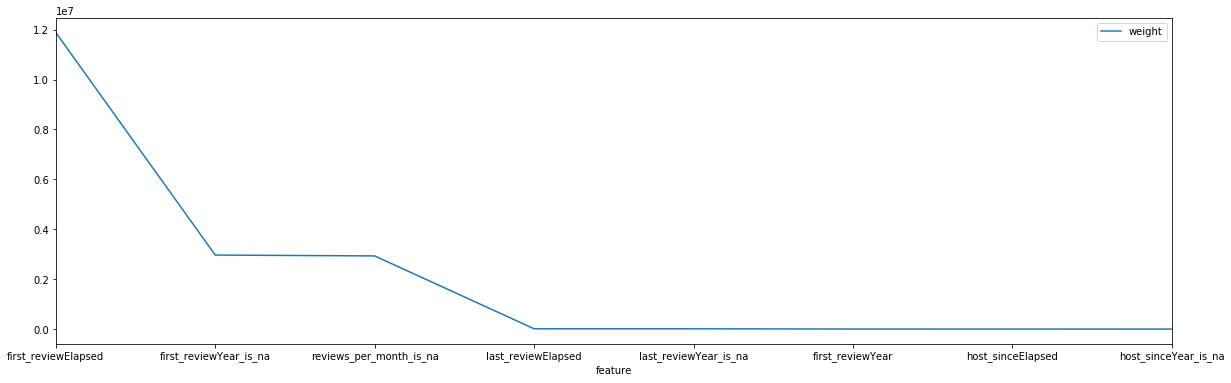

In [129]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(20, 6)
ax = fig.add_subplot(111)
exp_df[:8].plot(x = 'feature', y = 'weight', ax = ax)


### Summary

In this lesson, we used permutation feature importance to reduce our number of features from over 300 to the top 50.  We also removed our repeating na features.  We saw that by removing only repeated features, or those features that had an importance score of less than .005, we were able to maintain our model's accuracy score. 

### Resources

[Interpretable ML Book](https://christophm.github.io/interpretable-ml-book/)